In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def print_pop(population):
    for i in population:
        print(i)

In [3]:
def initialize_map(p_zero, N):
    
    the_map = np.zeros((N,N))
    
    for i in range(0, N):
        for j in range(0, i):
            if random.random() > p_zero:
                the_map[i][j] = random.random()
                the_map[j][i] = the_map[i][j]
                
    return the_map

In [4]:
def initialize_complex_map(p_zero, N, groups):

    the_map = np.zeros((N,N))
    
    for i in range(0, N):
        for j in range(0, i):
            group_i = int(i/(N/groups))
            group_j = int(j/(N/groups))
            
            if random.random() > p_zero and abs(group_i - group_j) <= 1:
                the_map[i][j] = random.random()
                the_map[j][i] = the_map[i][j]
          
        
    ax = sns.heatmap(the_map)

    plt.show()
        
    return the_map   

In [5]:
def create_starting_population(size, the_map):
    
    population = []
    
    for i in range(0,size):
        population.append(create_new_member(the_map))
        
    return population

In [6]:
def fitness(route, the_map):
    
    score = 0
    
    for i in range(1, len(route)):
        if (the_map[route[i-1]][route[i]] == 0) and i != len(the_map)-1:
            print("WARNING: INVALID ROUTE")
            print(route)
            print(the_map)
        score = score + the_map[route[i-1]][route[i]]

    return score

In [7]:
def crossover(a, b):
    
    common_elements = set(a) & set(b)
    
    if len(common_elements) == 2:
        return (a, b)
    else:
        common_elements.remove(0)
        common_elements.remove(max(a)) 
        value = random.sample(common_elements, 1)        
    
    cut_a = np.random.choice(np.where(np.isin(a, value))[0])
    cut_b = np.random.choice(np.where(np.isin(b, value))[0])
    
    new_a1 = copy.deepcopy(a[0:cut_a])
    new_a2 = copy.deepcopy(b[cut_b:])
    
    new_b1 = copy.deepcopy(b[0:cut_b])
    new_b2 = copy.deepcopy(a[cut_a:])
    
    new_a = np.append(new_a1, new_a2)
    new_b = np.append(new_b1, new_b2)
       
    return (new_a, new_b)

In [8]:
def mutate(route, probability, the_map):
    
    new_route = copy.deepcopy(route)
    
    for i in range(1, len(new_route)):
        if random.random() < probability:
            
            go = True

            while go:

                possible_values = np.nonzero(the_map[new_route[i-1]])
                proposed_value = random.randint(0,len(possible_values[0])-1)
                route = np.append(new_route, possible_values[0][proposed_value])

                if new_route[i] == len(the_map)-1:
                    go = False
                else:
                    i += 1
    
    return new_route

In [9]:
def create_new_member(the_map):

    N = len(the_map)
    
    route = np.zeros(1, dtype=int)

    go = True
    
    i = 1
    
    while go:
        
        possible_values = np.nonzero(the_map[route[i-1]])
        proposed_value = random.randint(0,len(possible_values[0])-1)
        route = np.append(route, possible_values[0][proposed_value])
                
        if route[i] == N-1:
            go = False
        else:
            i += 1
    
    return route

In [10]:
def score_population(population, the_map):
    
    scores = []
    
    for i in range(0, len(population)):
        scores += [fitness(population[i], the_map)]
        
    return scores
        

In [11]:
def pick_mate(scores):

    array = np.array(scores)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))

    fitness = [len(ranks) - x for x in ranks]
    
    cum_scores = copy.deepcopy(fitness)
    
    for i in range(1,len(cum_scores)):
        cum_scores[i] = fitness[i] + cum_scores[i-1]
        
    probs = [x / cum_scores[-1] for x in cum_scores]
    
    rand = random.random()
    
    for i in range(0, len(probs)):
        if rand < probs[i]:
            
            return i

In [12]:
def main():
    
    # parameters
    sparseness_of_map = 0.95
    size_of_map = 1000
    population_size = 30
    number_of_iterations = 1000
    number_of_couples = 9
    number_of_winners_to_keep = 2
    mutation_probability = 0.05
    number_of_groups = 1
    
    # inisialisasi map
    the_map = initialize_complex_map(sparseness_of_map, size_of_map, number_of_groups)

    # mulai populasi
    population = create_starting_population(population_size, the_map)

    last_distance = 1000000000

        
    for i in range(0,number_of_iterations):
        new_population = []
        
        
        #evaluasi fitnes atau jarak dari population
        scores = score_population(population, the_map)

        best = population[np.argmin(scores)]
        number_of_moves = len(best)
        distance = fitness(best, the_map)
        
        if distance != last_distance:
            print('Iteration %i: Best so far is %i steps for a distance of %f' % (i, number_of_moves, distance))
            plot_best(the_map, best, i)

        
  
        for j in range(0, number_of_couples):  
            new_1, new_2 = crossover(population[pick_mate(scores)], population[pick_mate(scores)])
            new_population = new_population + [new_1, new_2]
  
        # mutasi
        for j in range(0, len(new_population)):
            new_population[j] = np.copy(mutate(new_population[j], 0.05, the_map))
            
        
        new_population += [population[np.argmin(scores)]]
        for j in range(1, number_of_winners_to_keep):
            keeper = pick_mate(scores)            
            new_population += [population[keeper]]
            
    
        #menambahkan member baru secara acak
        while len(new_population) < population_size:
            new_population += [create_new_member(the_map)]
            
 
        #menggantikan populasi lama dengan hasil copy 
        population = copy.deepcopy(new_population)
                
        last_distance = distance
        
    # plot the results

In [13]:
def plot_best(the_map, route, iteration_number):
    ax = sns.heatmap(the_map)

    x=[0.5] + [x + 0.5 for x in route[0:len(route)-1]] + [len(the_map) - 0.5]
    y=[0.5] + [x + 0.5 for x in route[1:len(route)]] + [len(the_map) - 0.5]
    
    plt.plot(x, y, marker = 'o', linewidth=4, markersize=12, linestyle = "-", color='white')
#     plt.savefig('images/new1000aplot_%i.png' %(iteration_number), dpi=300)
    plt.show()
    

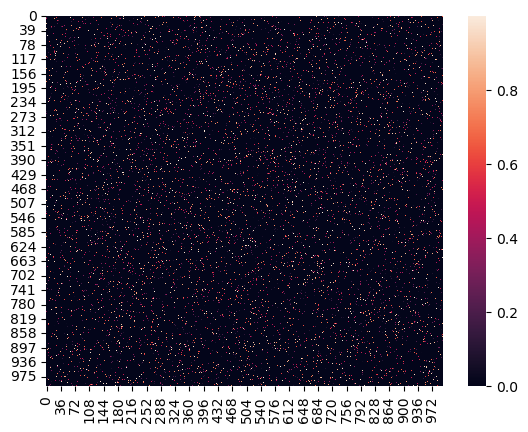

Iteration 0: Best so far is 4 steps for a distance of 2.765888


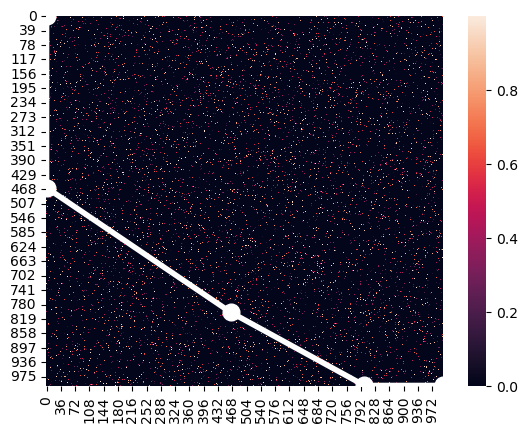

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9672\2937592031.py:14: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  value = random.sample(common_elements, 1)


Iteration 4: Best so far is 3 steps for a distance of 1.399655


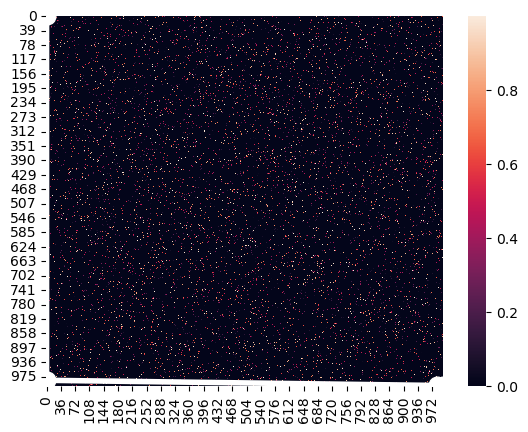

Iteration 21: Best so far is 3 steps for a distance of 0.516597


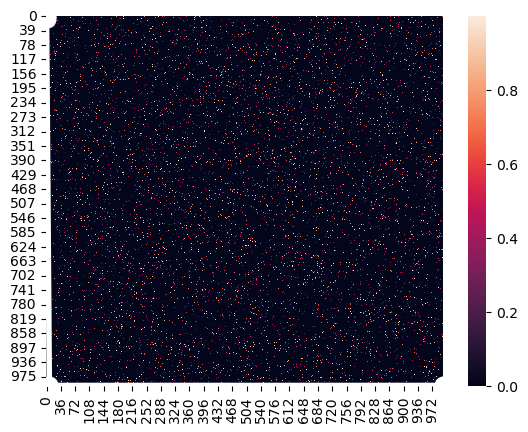

Iteration 641: Best so far is 4 steps for a distance of 0.479873


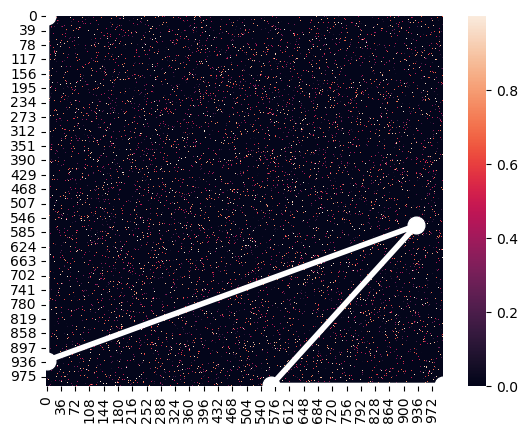

In [14]:
main()